In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from rl_analysis.plotting import (
    setup_plotting_env,
    syllable_aliases,
    clean_ticks,
    savefig
)

from rl_analysis.util import rle, count_transitions
from rl_analysis.io.df import get_closed_loop_parquet_columns

In [2]:
targets = [20, 27, 59, 76, 17, 30]
force = False

nlags = 3
eps = 1e-9
burn_in = 0

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [9]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]
# dask_address = analysis_config["dask"].get("address")

# Use actual calls...

In [10]:
save_file = os.path.join(
    raw_dirs["misc"], "f1_scores_estimates_actual_calls.parquet"
)

In [11]:
call_df = pd.read_parquet(save_file)

In [12]:
rle_call_df = call_df.drop_duplicates(["uuid", "syllable_num"]).copy()
rle_call_df.index = range(len(rle_call_df))
any_feedback_calls = (
    call_df.groupby(["uuid", "syllable_num"])["feedback_call"]
    .any()
    .rename("is_feedback")
)

In [13]:
# allow ourselves a little slop...
rle_call_df["is_prev_target"] = rle_call_df.groupby("uuid")["is_target"].shift(
    +1, fill_value=False
)
rle_call_df["is_target"] = rle_call_df["is_target"] | rle_call_df["is_prev_target"]

In [14]:
# turn into RLE, group by mouse etc. etc.
# count everything on RLE basis

In [15]:
rle_call_df = pd.concat(
    [rle_call_df.set_index(["uuid", "syllable_num"]), any_feedback_calls], axis=1
)
rle_call_df = rle_call_df.reset_index()
feedback_counts = rle_call_df.groupby(
    ["is_feedback", "area", "mouse_id", "opsin", "target_syllable"]
)["is_target"].value_counts()

In [16]:
true_positives = feedback_counts.xs((True, True), level=("is_feedback", "is_target"))
false_positives = feedback_counts.xs((True, False), level=("is_feedback", "is_target"))
true_negatives = feedback_counts.xs((False, False), level=("is_feedback", "is_target"))
false_negatives = feedback_counts.xs((False, True), level=("is_feedback", "is_target"))

In [17]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
false_discovery = false_positives / (false_positives + true_positives)

In [18]:
f1_score = lambda p, r: (2 * (p * r)) / (p + r + 0.01)
f1_score_df = f1_score(precision, recall).rename("f1_score")

In [19]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = []
for k, v in learner_dct.items():
    learners += v["learners"]

In [20]:
x = "precision"
learning_y = "log2_fold_change_count"

In [21]:
norm_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_aggregate.parquet"
    )
)

In [22]:
learning_norm_df = (
    norm_df.loc[
        (norm_df["session_number"].isin([1, 2]))
    ]
    .groupby(
        ["area", "target_syllable", "syllable", "mouse_id", "opsin", "session_number"]
    )
    .mean()[learning_y]
)

/tmp/ipykernel_1598940/3293482174.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()[learning_y]


In [23]:
group_keys = ["area", "target_syllable", "mouse_id", "opsin"]

In [24]:
on_target_learning = learning_norm_df.loc[
    learning_norm_df.index.get_level_values("syllable")
    == learning_norm_df.index.get_level_values("target_syllable")
]
on_target_learning.index = on_target_learning.index.droplevel("syllable")

In [25]:
compare_df = pd.concat(
    [
        f1_score_df.groupby(group_keys).mean(),
        false_positives.groupby(group_keys).mean().rename("false_positives"),
        false_discovery.groupby(group_keys).mean().rename("false_discovery"),
        precision.groupby(group_keys).mean().rename("precision"),
        recall.groupby(group_keys).mean().rename("recall"),
    ],
    axis=1,
).dropna()

In [26]:
compare_df = compare_df.join(on_target_learning)

In [27]:
compare_df.loc[
    compare_df.index.get_level_values("mouse_id").isin(learners), "learner"
] = True
compare_df["learner"] = compare_df["learner"].fillna(False)
compare_df = compare_df.set_index("learner", append=True)

In [28]:
aliases = {
    "f1_score": "F1 score",
    "precision": "precision",
    "recall": "recall",
    "false_discovery": "False discovery rate",
    "false_positives": "False positives",
}

In [32]:
fname = os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet")
cols = get_closed_loop_parquet_columns(fname, pcs=False, likes=False)

In [33]:
feedback_df = pd.read_parquet(
    fname,
    filters=[
        ("experiment_type", "=", "reinforcement"),
        ("area", "in", ["ctrl", "snc (axon)"]),
    ],
).sort_index()
# filters out any sessions that where prematurely cut off

In [34]:
feedback_df = feedback_df[feedback_df["date"].dt.dayofweek == 0].copy()

In [35]:
rle_df = feedback_df.groupby("uniq_id")["predicted_syllable"].apply(rle)

In [36]:
rle_df = feedback_df.loc[rle_df.index.get_level_values(-1)]

In [37]:
tms = rle_df.groupby(["mouse_id", "uniq_id"], observed=True)[
    "predicted_syllable"
].apply(lambda x: count_transitions(x, K=100))

In [38]:
tm = tms.groupby("mouse_id", observed=True).apply(np.mean)

In [39]:
tm_p_out = tm.apply(lambda x: x / (x.sum(axis=1, keepdims=True) + 0.01))
tm_p_in = tm.apply(lambda x: x / (x.sum(axis=0, keepdims=True) + 0.01))

In [40]:
# build out TMs...

## Build a confusion matrix among targets

In [41]:
rle_call_df.dropna(subset=["true_labels", "target_syllable"], inplace=True)
rle_call_df = rle_call_df.loc[rle_call_df["true_labels"].astype("int") > 0].copy()

In [42]:
rle_call_df["true_labels"] = rle_call_df["true_labels"].astype("int").astype("category")
rle_call_df["target_syllable"] = (
    rle_call_df["target_syllable"].astype("int").astype("category")
)
rle_call_df["in_targets"] = rle_call_df["true_labels"].isin(targets)

In [43]:
rle_call_df["true_labels_censored"] = rle_call_df["true_labels"].copy()

In [44]:
mask = rle_call_df["is_prev_target"] & rle_call_df["is_feedback"]

In [45]:
rle_call_df.loc[mask, "true_labels_censored"] = np.nan
rle_call_df.loc[mask, "true_labels_censored"] = rle_call_df.groupby("uuid")[
    "true_labels"
].shift(+1)[mask]

In [46]:
all_syllables = rle_call_df["true_labels"].cat.categories

In [47]:
feedback_counts = (
    rle_call_df.groupby(
        ["is_feedback", "area", "mouse_id", "opsin", "target_syllable"]
    )["true_labels_censored"]
    .value_counts(dropna=False)
    .rename("count")
)

In [48]:
feedback_counts.index = feedback_counts.index.set_names("true_labels", level=-1)

In [49]:
feedback_counts = feedback_counts.xs(True, level="is_feedback")

In [50]:
feedback_counts = feedback_counts.reindex(
    all_syllables, level="true_labels", fill_value=0
)

In [51]:
target_counts = feedback_counts.loc[
    feedback_counts.index.get_level_values("true_labels").isin(targets)
]
nontarget_counts = feedback_counts.loc[
    ~feedback_counts.index.get_level_values("true_labels").isin(targets)
]

In [52]:
all_counts = feedback_counts.loc[
    feedback_counts.index.get_level_values("true_labels").astype("int")
    != feedback_counts.index.get_level_values("target_syllable").astype("int")
]

In [53]:
all_counts = all_counts.reset_index().set_index(
    ["target_syllable", "true_labels", "opsin", "mouse_id", "area"]
)

In [55]:
ave_tm_p_out = tm_p_out.mean()
ave_tm_p_in = tm_p_in.mean()

In [56]:
for _target in targets:

    exclude_out = np.flatnonzero(ave_tm_p_out[_target] > 0.1)
    exclude_in = np.flatnonzero(ave_tm_p_in[:, _target] > 0.1)
    exclude = list(set(list(exclude_out) + list(exclude_in)))
    for _exclude in exclude:
        all_counts.loc[_target, _exclude] = np.nan
    print(exclude)

[74, 27, 12]
[20, 5, 22]
[8, 43, 76, 45, 13, 85]
[8, 59, 43, 27]
[41, 27, 5, 22]
[67]


/tmp/ipykernel_1598940/1818967230.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_counts.loc[_target, _exclude] = np.nan


In [57]:
average_off_target_count = all_counts.groupby(["target_syllable", "true_labels"]).sum()[
    "count"
]

In [58]:
average_off_target_rank = (
    average_off_target_count.groupby("target_syllable")
    .apply(lambda x: x.loc[x > 0].dropna().rank(ascending=False, method="dense"))
    .rename("rank")
)
average_off_target_rank.index = average_off_target_rank.index.droplevel(0)

In [59]:
syllable_confusion_df = pd.concat(
    [average_off_target_rank, average_off_target_count], axis=1
)

In [60]:
most_confused_syllables = syllable_confusion_df["rank"]

In [61]:
nontarget_counts = (
    nontarget_counts.groupby(["mouse_id", "target_syllable"])
    .sum()
    .groupby("target_syllable")
    .mean()
    .rename("all_others")
)

In [62]:
confusion_matrix = (
    target_counts.groupby(["target_syllable", "true_labels"]).mean().unstack()
)
confusion_matrix = confusion_matrix.loc[targets, targets]
confusion_matrix.columns = confusion_matrix.columns.map(syllable_aliases)

confusion_matrix["others (ave.)"] = nontarget_counts
confusion_matrix.index = confusion_matrix.index.map(syllable_aliases)

In [63]:
confusion_matrix.columns.name = "Offline syllable call"
confusion_matrix.index.name = "Online syllable call"

In [64]:
setup_plotting_env()

In [67]:
norm_matrix = confusion_matrix / confusion_matrix.to_numpy().sum(axis=1, keepdims=True)
norm_matrix[norm_matrix < 1e-3] = 0

In [68]:
target_colors = sns.color_palette("bright", n_colors=len(targets))

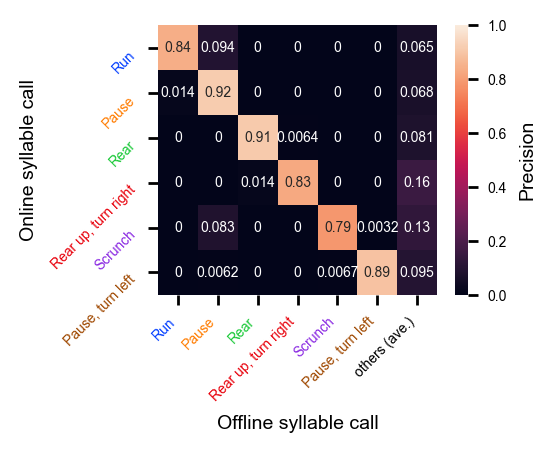

In [70]:
fig, ax = plt.subplots(1, figsize=(2.25, 1.75))
sns.heatmap(
    norm_matrix,
    annot=True,
    fmt=".2g",
    vmin=0,
    vmax=1,
    annot_kws={"size": 5},
    cbar_kws={"label": "Precision"},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")
[_.set_color(_color) for _, _color in zip(ax.get_xticklabels(), target_colors)]
[_.set_color(_color) for _, _color in zip(ax.get_yticklabels(), target_colors)]

savefig(
    fig, os.path.join(figure_cfg["store_dir"], "online_syllable_call_precision_matrix")
)

In [71]:
on_target_learning = learning_norm_df.loc[
    learning_norm_df.index.get_level_values("syllable")
    == learning_norm_df.index.get_level_values("target_syllable")
]
on_target_learning.index = on_target_learning.index.droplevel("syllable")

In [73]:
indices = on_target_learning.index.names
on_target_learning = on_target_learning.reset_index()
on_target_learning["rank"] = 0
on_target_learning = on_target_learning.set_index(list(indices) + ["rank"])
on_target_learning = on_target_learning[learning_y]

In [74]:
dfs = []
for tup in most_confused_syllables.iteritems():
    # print(tup)
    _df = learning_norm_df.xs(tup[0], level=("target_syllable", "syllable"))
    _df = _df.reset_index()
    _df["target_syllable"] = tup[0][0]
    _df["rank"] = tup[1]
    _df = _df.set_index(on_target_learning.index.names)
    dfs.append(_df)

/tmp/ipykernel_1598940/628585002.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for tup in most_confused_syllables.iteritems():


In [75]:
off_target_learning = pd.concat(dfs)[learning_y]

In [76]:
compare_df = pd.concat(
    [
        f1_score_df.groupby(group_keys).mean(),
        false_positives.groupby(group_keys).mean().rename("false_positives"),
        false_discovery.groupby(group_keys).mean().rename("false_discovery"),
        precision.groupby(group_keys).mean().rename("precision"),
        recall.groupby(group_keys).mean().rename("recall"),
    ],
    axis=1,
)

In [77]:
compare_df = compare_df.join(pd.concat([on_target_learning, off_target_learning]))

In [78]:
compare_df.loc[
    compare_df.index.get_level_values("mouse_id").isin(learners), "learner"
] = True
compare_df["learner"] = compare_df["learner"].fillna(False)
compare_df = compare_df.set_index("learner", append=True)

In [79]:
dat = compare_df.xs("chr2", level="opsin").loc["snc (axon)"]

In [81]:
nmice = dat.index.get_level_values("mouse_id").nunique()
nsyllables = dat.index.get_level_values("target_syllable").nunique()

In [82]:
x = "precision"
y = "target_learning"

In [83]:
show_syllables = 10

In [84]:
plt_df = (
    compare_df.xs(("snc (axon)", "chr2", True), level=("area", "opsin", "learner"))
    .groupby(["mouse_id", "rank", "session_number"])["log2_fold_change_count"]
    .mean()
)

In [85]:
plt_df = plt_df.loc[:, :show_syllables]

In [86]:
ref = plt_df.groupby("mouse_id").first()

In [87]:
plt_df = plt_df.sort_index()
plt_df.loc[:, 1:] = (
    plt_df.loc[:, 1:]
    .groupby(["mouse_id", "session_number"])
    .apply(lambda x: x.rolling(3, 1, True).mean())
)

/tmp/ipykernel_1598940/2107458566.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.rolling(3, 1, True).mean())


In [88]:
plt_df = plt_df.reset_index()

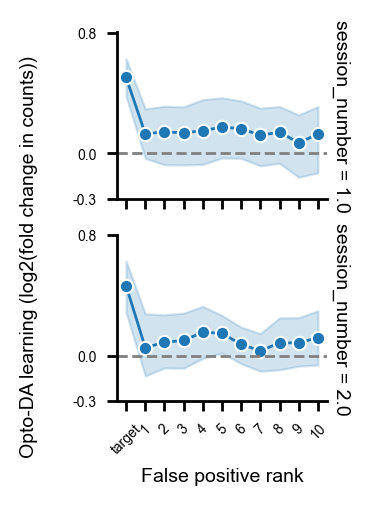

In [89]:
g = sns.relplot(
    data=plt_df,
    x="rank",
    marker="o",
    row="session_number",
    y="log2_fold_change_count",
    kind="line",
    facet_kws={"margin_titles": True},
)
g.refline(y=0)
g.fig.set_size_inches(1.8, 2.5)
# g.axes.flat[0].set_ylim(-.5,.7)
for _ax in g.axes.flat:
    clean_ticks(_ax, "y", precision=1, zero_symmetry=False)
# plt.xticks(rotation=45)
plt.xlim(-0.5, show_syllables + 0.5)
plt.xticks(
    range(show_syllables + 1),
    labels=["target"] + list(range(1, show_syllables + 1)),
    rotation=45,
    ha="center",
)
g.set_axis_labels("False positive rank", "")
g.fig.supylabel("Opto-DA learning (log2(fold change in counts))", fontsize=7)
g.fig.tight_layout()
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], f"false_positive_ranked_optodalearning"),
)